# Utility functions (rotate-and-crop and draw-grid)


In [1]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def rotate_and_crop(image_path, alpha, x, y, z, w):
    img = Image.open(image_path)
    img_rotated = img.rotate(alpha, expand=True)
    cropped_img = img_rotated.crop((x, y, z, w))

    return cropped_img


In [2]:
def draw_grid_on_image(image, x, y, z):
    # Define the grid parameters
    grid_size = 14
    square_size = z

    # Draw grid
    for i in range(grid_size):
        for j in range(grid_size):
            square_x = x + j * square_size
            square_y = y + i * square_size
            square_z = square_x + square_size
            square_w = square_y + square_size
            cv2.rectangle(image, (square_x, square_y), (square_z, square_w), (0, 0, 255), 3)

    return image


# Get first board image to use it as reference: load it and warp perspective to be viewed from top

In [3]:
import cv2
import numpy as np

def warp_perspective(image, src_points, dst_points):
    image_np = np.array(image)

    # compute perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    # apply perspective transformation
    warped_image = cv2.warpPerspective(image_np, matrix, (image.width, image.height))

    warped_image_pil = Image.fromarray(warped_image)

    return warped_image_pil

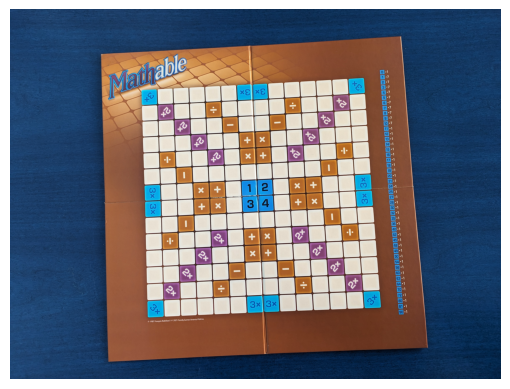

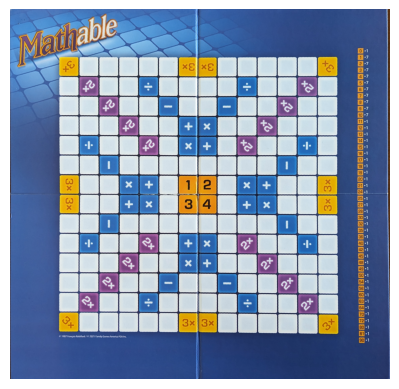

In [38]:
# First board
image_path = "board+tokens/board1.jpg"
alpha = -2.9  # Rotation angle in degrees
x, y = 800, 390  # Top-left corner
z, w = 3480, 3000 # Bottom-right corner

base_image = rotate_and_crop(image_path, alpha, x, y, z, w)

# Manually set source points as corners of the real board vs dest points as corners of the image
src_points = np.array([[95, 25], [base_image.width-73, 15], [base_image.width, base_image.height-40], [20, base_image.height-40]], dtype=np.float32)
dst_points = np.array([[0, 0], [base_image.width, 0], [base_image.width, base_image.height], [0, base_image.height]], dtype=np.float32)

# Warp the perspective of the image
warped_image = warp_perspective(base_image, src_points, dst_points)

plt.imshow(cv2.imread(image_path))
plt.axis('off')
plt.show()

plt.imshow(warped_image)
plt.axis('off')
plt.show()

# Warp each images to match base image

In [6]:
import numpy as np

def get_keypoints(image = None, image_path = None):

    if image is None:
      image = cv2.imread(image_path)
    # Grayscale the image and get BRISK keypoints and descriptors
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    BRISK = cv2.BRISK_create()

    keypoints1, descriptors1 = BRISK.detectAndCompute(gray, None)

    # Draw keypoints on images (for debugging)
    image_keypoints = cv2.drawKeypoints(gray, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    image_keypoints_rgb = cv2.cvtColor(image_keypoints, cv2.COLOR_BGR2RGB)


    return keypoints1, descriptors1

open_cv_image = cv2.cvtColor(np.array(warped_image), cv2.COLOR_RGB2BGR)

In [8]:
import time

keypoints_base, descriptors_base = get_keypoints(image = open_cv_image, image_path = None)

def warp_image_to_base(image = None, image_path = None, base_image = open_cv_image):
  if image is None:
    image = cv2.imread(image_path)
  # Get keypoints and descriptors
  keypoints, descriptors = get_keypoints(image = image)

  # Do descriptors knnMatching using FLANN between current image and base image
  FLANN_INDEX_LSH = 6
  index_params= dict(algorithm = FLANN_INDEX_LSH,
    table_number = 6,
    key_size = 12,
    multi_probe_level = 1)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params,search_params)
  matches = flann.knnMatch(descriptors_base,descriptors,k=2)

  # Get good matches
  good_matches = []
  for m, n in matches:
    if m.distance < 0.70 * n.distance:
      good_matches.append(m)

  # Find homography and warp
  src = np.float32([ keypoints_base[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
  dist = np.float32([ keypoints[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

  homography_matrix, _ = cv2.findHomography(dist, src, cv2.RANSAC,5.0)
  h,w, _ = base_image.shape

  imgOutput = cv2.warpPerspective(image, homography_matrix, (w, h), cv2.INTER_LINEAR)


  return imgOutput

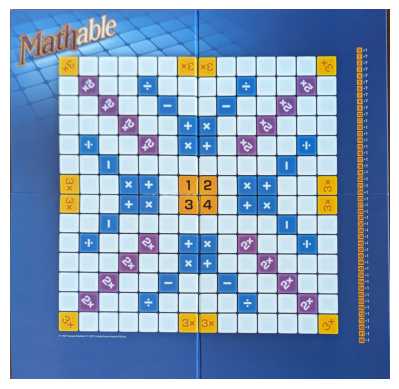

In [9]:
output = warp_image_to_base(image_path = 'board+tokens/board3.jpg')

output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
#output = draw_grid_on_image(output, 340, 310, 141)
plt.imshow(output)
plt.axis('off')
plt.show()

# Process warped images and extract numbers

In [11]:
def process(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    ret3,th3 = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(th3, kernel, iterations=1)

    return dilated

In [12]:
import os
import time

processed_path = "processed"

if not os.path.exists(processed_path):
    os.makedirs(processed_path)


board_source = "board+tokens"
train_source = "train"

def add_processed_to_folder(source):
  i = 0
  for root, dirs, files in os.walk(source):
      for file in files:
          if file.endswith(".jpg"):
              file_path = os.path.join(root, file)
              output = warp_image_to_base(image_path = file_path)
              processed_image = process(output)
              # Write the processed image to the "processed" folder
              processed_file_path = os.path.join(processed_path, file)
              cv2.imwrite(processed_file_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))
              print("Processed image saved to:", processed_file_path)
              i += 1
              print(i)

add_processed_to_folder(board_source)
add_processed_to_folder(train_source)

Processed image saved to: processed\board1.jpg
1
Processed image saved to: processed\board2.jpg
2
Processed image saved to: processed\board3.jpg
3
Processed image saved to: processed\board4.jpg
4
Processed image saved to: processed\board5.jpg
5
Processed image saved to: processed\tokens1.jpg
6
Processed image saved to: processed\tokens10.jpg
7
Processed image saved to: processed\tokens11.jpg
8
Processed image saved to: processed\tokens12.jpg
9
Processed image saved to: processed\tokens2.jpg
10
Processed image saved to: processed\tokens3.jpg
11
Processed image saved to: processed\tokens4.jpg
12
Processed image saved to: processed\tokens5.jpg
13
Processed image saved to: processed\tokens6.jpg
14
Processed image saved to: processed\tokens7.jpg
15
Processed image saved to: processed\tokens8.jpg
16
Processed image saved to: processed\tokens9.jpg
17
Processed image saved to: processed\1_01.jpg
1
Processed image saved to: processed\1_02.jpg
2
Processed image saved to: processed\1_03.jpg
3
Pro

# Extract squares for model training from b+t and train folders

In [13]:
def extract_square(image, coords):
  row = coords[0]
  column = ord(coords[1]) - ord('A') + 1

  square_x = 340 + (column-1) * 141
  square_y = 312 + (row-1) * 141

  square_z = square_x + 141
  square_w = square_y + 141

  square = image[square_y:square_w, square_x:square_z]

  return square

# image = cv2.imread("/content/extracted/processed/tokens4.jpg")
# square = extract_square(image, (6, 'N'))

# plt.imshow(square)
# plt.axis('off')
# plt.show()

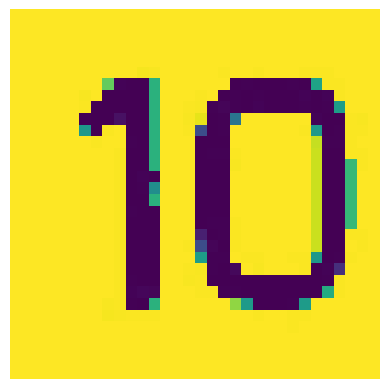

In [14]:
def get_all_squares(image):
  squares = []
  for i in range(1, 15):
    for l in range(0, 14):
      ltr = chr(ord('A') + l)
      square = extract_square(image, (i, ltr))
      if len(square.shape) == 3:
        height, width, _ = square.shape
      else:
        height, width = square.shape

      crop_percent = 0.1
      # Calculate the number of pixels to crop from each side
      crop_pixels = int(min(height, width) * crop_percent)
      # Crop the image
      square = square[crop_pixels:height-crop_pixels, crop_pixels:width-crop_pixels]

      square = cv2.resize(square, (32, 32))
      squares.append(square)
  return squares

image = cv2.imread("processed/tokens4.jpg", cv2.IMREAD_GRAYSCALE)
squares = get_all_squares(image)

plt.imshow(squares[75])
plt.axis('off')
plt.show()

In [15]:
nmb_list = [i for i in range(0, 22)] + [24, 25, 27, 28, 30, 32, 35, 36, 40, 42, 45, 48, 49, 50, 54, 56, 60, 63, 64, 70, 72, 80, 81, 90]

keys = ['a', 'b', 'c']
values = [1, 2, 3]
nmb_to_lbl = dict(zip(nmb_list, [i for i in range(0, 46)]))
lbl_to_nmb = dict(zip([i for i in range(0, 46)], nmb_list))

def get_training_data(return_verbose = False):
  train_path = "train"
  X = []
  for i in range(1, 5):
    image_path = os.path.join(processed_path, f"{i}_50.jpg")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    squares = get_all_squares(img)
    for j in range(1, 51):
      if j < 10:
        label_file = f"{i}_0{j}.txt"
      else:
        label_file = f"{i}_{j}.txt"

      label_file = os.path.join(train_path, label_file)
      with open(label_file) as f:
        label = f.readline()
      label = label.split(' ')
      number = int(label[1])
      row = int(label[0][:-1])
      column = ord(label[0][-1]) - ord('A') + 1
      img_idx = (row-1) * 14 + column - 1
      img_dict = {'image': squares[img_idx], 'row': row, 'column': column, 'number': number}
      X.append(img_dict)

  # either return full data(list of dicts) or data for CNN training(X and Y arrays)
  if return_verbose:
    return X
  else:
    x = []
    y = []
    for d in X:
      x.append(d['image'])
      y.append(nmb_to_lbl[d['number']])
    return x, y

In [16]:
def get_training_data_boards():
  train_path = "processed"
  X = []
  Y = []
  for i in range(1, 7):
    image_path = os.path.join(train_path, f"tokens{i}.jpg")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    squares = get_all_squares(img)
    nmb_idx = 0
    for j in range(5, 11):
      for k in range(4, 12):
        img_idx = (j-1) * 14 + k - 1
        if nmb_idx < 46:
          X.append(squares[img_idx])
          Y.append(nmb_to_lbl[nmb_list[nmb_idx]])
          nmb_idx += 1

  for i in range(7, 13):
    image_path = os.path.join(train_path, f"tokens{i}.jpg")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    squares = get_all_squares(img)
    nmb_idx = 0
    for j in range(1, 14, 2):
      for k in range(1, 14, 2):
        img_idx = (j-1) * 14 + k - 1
        if nmb_idx < 46:
          X.append(squares[img_idx])
          Y.append(nmb_to_lbl[nmb_list[nmb_idx]])
          nmb_idx += 1

  return X, Y

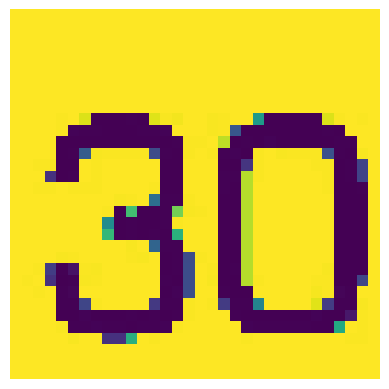

26


In [17]:
from collections import Counter

x, y = get_training_data_boards()
x1, y1 = get_training_data()
x = x + x1
y = y + y1
i = 256
plt.imshow(x[i])
plt.axis('off')
plt.show()
print(y[i])

# Train CNN

In [18]:

import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

X_tensor = torch.tensor(x) / 255.0
Y_tensor = torch.tensor(y)

class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(Y_tensor.numpy()), y = Y_tensor.numpy())
class_weights = torch.tensor(class_weights,dtype=torch.float)

X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\seraf\AppData\Local\Temp\ipykernel_11244\570090418.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_tensor = torch.tensor(x) / 255.0


In [19]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1)
        self.fc1 = nn.Linear(in_features = 2 * 2 * 64, out_features = 64)
        self.fc2 = nn.Linear(in_features = 64, out_features = 46)
        self.activation_fn = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.activation_fn(self.conv1(x))
        x = self.pool(x)
        x = self.activation_fn(self.conv2(x))
        x = self.pool(x)
        x = self.activation_fn(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.activation_fn(self.fc1(x))
        x = self.fc2(x)
        return x


In [20]:
def epoch_train(dataloader, model, loss_crt, optimizer):
    model.train()
    num_batches = len(dataloader)
    loss_epoch = 0.0
    accuracy = 0.0

    for _ , batch in tqdm(enumerate(dataloader)):
        images, labels = batch
        model.zero_grad()

        model_output = model(images)
        loss = loss_crt(model_output, labels.squeeze())

        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        prediction = model_output.argmax(dim=1, keepdim=True)

        accuracy += prediction.eq(labels.view_as(prediction)).float().mean().item()

    loss_epoch = loss_epoch/num_batches
    accuracy = accuracy/num_batches
    return loss_epoch, 100. * accuracy

def epoch_eval(dataloader, model, loss_crt):

    model.eval()
    num_batches = len(dataloader)
    loss_epoch = 0.0
    accuracy = 0.0
    with torch.no_grad():
        for _, batch in tqdm(enumerate(dataloader)):
            images, labels = batch
            batch_sz = images.size(0)

            model_output = model(images)

            loss = loss_crt(model_output, labels.squeeze())

            loss_epoch += loss.item()

            prediction = model_output.argmax(dim=1, keepdim=True)
            accuracy += prediction.eq(labels.view_as(prediction)).float().mean().item()

    loss_epoch = loss_epoch/num_batches
    accuracy = accuracy/num_batches
    return loss_epoch, 100. * accuracy

In [21]:
torch.manual_seed(115)
cnn_model = CNN()

optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

loss_fn = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')

num_epochs = 40

for epoch in range(1, num_epochs+1):
  train_loss, train_acc = epoch_train(train_dataloader, cnn_model, loss_fn, optimizer)
  val_loss, val_acc = epoch_eval(test_dataloader, cnn_model, loss_fn)

  print('\nEpoch %d'%(epoch))
  print('training loss: %10.8f, accuracy: %10.8f'%(train_loss, train_acc))
  print('validation loss: %10.8f, accuracy: %10.8f'%(val_loss, val_acc))

19it [00:00, 23.54it/s]
5it [00:00, 75.75it/s]



Epoch 1
training loss: 3.83195019, accuracy: 0.82236842
validation loss: 3.84146771, accuracy: 1.25000000


19it [00:00, 31.18it/s]
5it [00:00, 75.61it/s]



Epoch 2
training loss: 3.82940501, accuracy: 1.15131579
validation loss: 3.84504080, accuracy: 1.87500000


19it [00:00, 31.04it/s]
5it [00:00, 76.32it/s]



Epoch 3
training loss: 3.82655514, accuracy: 2.67763157
validation loss: 3.84838219, accuracy: 0.62500000


19it [00:00, 29.73it/s]
5it [00:00, 76.44it/s]



Epoch 4
training loss: 3.82459223, accuracy: 2.63157895
validation loss: 3.84929628, accuracy: 0.62500000


19it [00:00, 31.52it/s]
5it [00:00, 68.01it/s]



Epoch 5
training loss: 3.82234304, accuracy: 2.39473683
validation loss: 3.85192456, accuracy: 1.87500000


19it [00:00, 32.38it/s]
5it [00:00, 76.59it/s]



Epoch 6
training loss: 3.82025036, accuracy: 2.18421052
validation loss: 3.85458574, accuracy: 0.62500000


19it [00:00, 31.34it/s]
5it [00:00, 67.83it/s]



Epoch 7
training loss: 3.81744962, accuracy: 2.30263158
validation loss: 3.85726509, accuracy: 0.62500000


19it [00:00, 30.49it/s]
5it [00:00, 67.96it/s]



Epoch 8
training loss: 3.81430429, accuracy: 1.97368421
validation loss: 3.85902100, accuracy: 0.62500000


19it [00:00, 32.36it/s]
5it [00:00, 76.57it/s]



Epoch 9
training loss: 3.80957208, accuracy: 1.97368421
validation loss: 3.85839067, accuracy: 0.62500000


19it [00:00, 32.61it/s]
5it [00:00, 76.51it/s]



Epoch 10
training loss: 3.80677950, accuracy: 1.97368421
validation loss: 3.85896916, accuracy: 1.25000000


19it [00:00, 30.95it/s]
5it [00:00, 76.57it/s]



Epoch 11
training loss: 3.80249407, accuracy: 2.96052632
validation loss: 3.85698185, accuracy: 1.25000000


19it [00:00, 30.36it/s]
5it [00:00, 68.14it/s]



Epoch 12
training loss: 3.79076969, accuracy: 7.49342104
validation loss: 3.85227365, accuracy: 3.36956523


19it [00:00, 29.52it/s]
5it [00:00, 67.70it/s]



Epoch 13
training loss: 3.77856371, accuracy: 3.94736842
validation loss: 3.84705915, accuracy: 1.25000000


19it [00:00, 31.27it/s]
5it [00:00, 69.85it/s]



Epoch 14
training loss: 3.75923532, accuracy: 9.34868420
validation loss: 3.83601418, accuracy: 2.50000000


19it [00:00, 31.05it/s]
5it [00:00, 68.30it/s]



Epoch 15
training loss: 3.72474933, accuracy: 7.21052630
validation loss: 3.79009509, accuracy: 3.12500000


19it [00:00, 29.50it/s]
5it [00:00, 79.41it/s]



Epoch 16
training loss: 3.64386192, accuracy: 11.44078946
validation loss: 3.71167240, accuracy: 3.75000000


19it [00:00, 31.95it/s]
5it [00:00, 76.21it/s]



Epoch 17
training loss: 3.43576392, accuracy: 12.19078945
validation loss: 3.43479824, accuracy: 8.85869563


19it [00:00, 30.70it/s]
5it [00:00, 69.97it/s]



Epoch 18
training loss: 3.00354428, accuracy: 18.72368420
validation loss: 2.88433595, accuracy: 18.85869563


19it [00:00, 31.92it/s]
5it [00:00, 68.49it/s]



Epoch 19
training loss: 2.46250969, accuracy: 27.99999996
validation loss: 2.34141240, accuracy: 31.95652187


19it [00:00, 31.53it/s]
5it [00:00, 70.73it/s]



Epoch 20
training loss: 1.93815980, accuracy: 41.50657889
validation loss: 1.91821365, accuracy: 40.81521749


19it [00:00, 30.69it/s]
5it [00:00, 77.15it/s]



Epoch 21
training loss: 1.55129662, accuracy: 52.59868424
validation loss: 1.75324435, accuracy: 50.43478251


19it [00:00, 30.08it/s]
5it [00:00, 76.45it/s]



Epoch 22
training loss: 1.31668821, accuracy: 55.15131574
validation loss: 1.40477916, accuracy: 59.29347873


19it [00:00, 29.15it/s]
5it [00:00, 76.59it/s]



Epoch 23
training loss: 0.92878496, accuracy: 70.73026331
validation loss: 1.00643041, accuracy: 68.15217376


19it [00:00, 30.83it/s]
5it [00:00, 76.14it/s]



Epoch 24
training loss: 0.66817891, accuracy: 77.02631574
validation loss: 0.98088279, accuracy: 68.66847873


19it [00:00, 30.29it/s]
5it [00:00, 68.17it/s]



Epoch 25
training loss: 0.45196991, accuracy: 84.11842114
validation loss: 0.67288201, accuracy: 81.14130378


19it [00:00, 31.63it/s]
5it [00:00, 76.81it/s]



Epoch 26
training loss: 0.35446676, accuracy: 89.28947355
validation loss: 0.73268574, accuracy: 76.27717376


19it [00:00, 30.24it/s]
5it [00:00, 76.92it/s]



Epoch 27
training loss: 0.35965698, accuracy: 89.05263167
validation loss: 0.65474074, accuracy: 80.40760875


19it [00:00, 32.65it/s]
5it [00:00, 68.56it/s]



Epoch 28
training loss: 0.23880265, accuracy: 91.35526325
validation loss: 0.58079514, accuracy: 85.51630378


19it [00:00, 30.72it/s]
5it [00:00, 68.57it/s]



Epoch 29
training loss: 0.19607176, accuracy: 93.44736840
validation loss: 0.69588663, accuracy: 80.02717376


19it [00:00, 32.36it/s]
5it [00:00, 55.91it/s]



Epoch 30
training loss: 0.15751107, accuracy: 94.73684211
validation loss: 0.69517655, accuracy: 85.51630378


19it [00:00, 31.92it/s]
5it [00:00, 76.47it/s]



Epoch 31
training loss: 0.09815479, accuracy: 96.17105252
validation loss: 0.67861580, accuracy: 85.13586998


19it [00:00, 30.66it/s]
5it [00:00, 76.53it/s]



Epoch 32
training loss: 0.03730587, accuracy: 98.84868421
validation loss: 0.51362111, accuracy: 89.51086998


19it [00:00, 31.09it/s]
5it [00:00, 61.48it/s]



Epoch 33
training loss: 0.01976054, accuracy: 99.50657895
validation loss: 0.49540114, accuracy: 91.38586998


19it [00:00, 28.48it/s]
5it [00:00, 76.73it/s]



Epoch 34
training loss: 0.01519967, accuracy: 99.34210526
validation loss: 0.49807078, accuracy: 91.38586998


19it [00:00, 30.09it/s]
5it [00:00, 68.27it/s]



Epoch 35
training loss: 0.00683846, accuracy: 99.83552632
validation loss: 0.49213468, accuracy: 90.13586998


19it [00:00, 31.93it/s]
5it [00:00, 68.29it/s]



Epoch 36
training loss: 0.00375908, accuracy: 100.00000000
validation loss: 0.48835360, accuracy: 90.76086998


19it [00:00, 30.71it/s]
5it [00:00, 61.65it/s]



Epoch 37
training loss: 0.00282519, accuracy: 100.00000000
validation loss: 0.49282094, accuracy: 91.38586998


19it [00:00, 30.33it/s]
5it [00:00, 76.73it/s]



Epoch 38
training loss: 0.00230745, accuracy: 100.00000000
validation loss: 0.49725300, accuracy: 91.38586998


19it [00:00, 31.11it/s]
5it [00:00, 76.97it/s]



Epoch 39
training loss: 0.00209984, accuracy: 100.00000000
validation loss: 0.50420722, accuracy: 91.38586998


19it [00:00, 30.59it/s]
5it [00:00, 76.32it/s]


Epoch 40
training loss: 0.00189690, accuracy: 100.00000000
validation loss: 0.50711769, accuracy: 91.38586998


# Iterate through all images in a game and calculate score

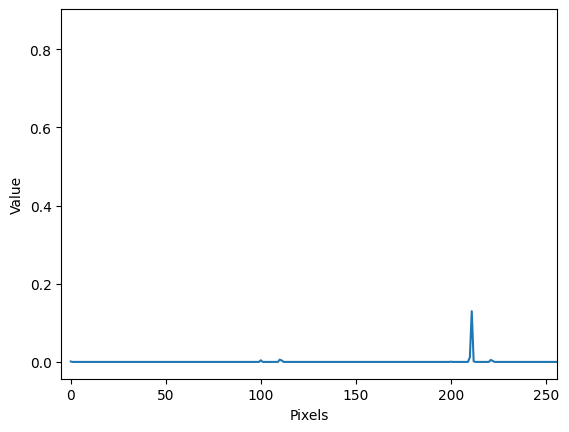

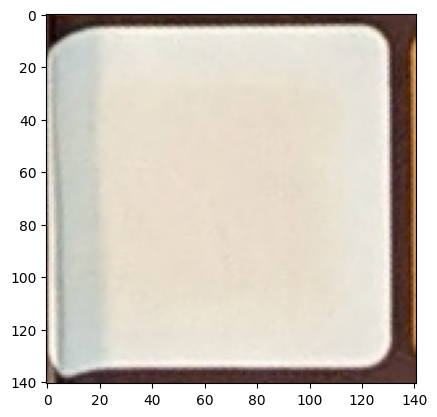

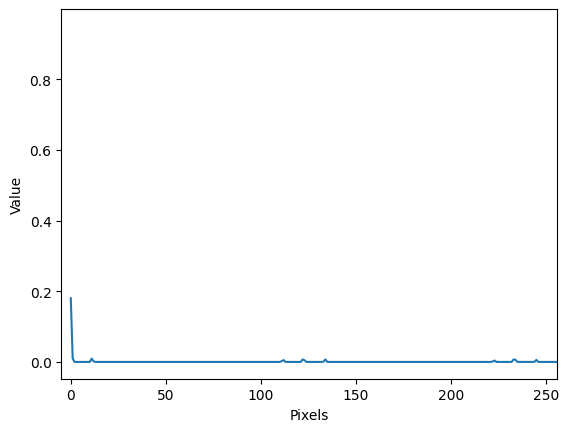

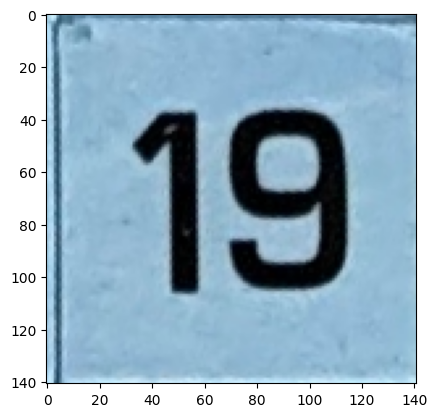

In [30]:
def get_histogram(image):
    channels=[0, 1, 2]
    size=[10, 10, 10]
    range=[0, 256, 0, 256, 0, 256]
    histogram = cv2.calcHist([image], channels, None, size, range)
    histogram = cv2.normalize(histogram, histogram).flatten()
    return histogram

def get_histogram_similarity(base, compare, method='correlation'):
    histogram_base = get_histogram(base)
    histogram_compare = get_histogram(compare)

    similarity = cv2.compareHist(histogram_base, histogram_compare, cv2.HISTCMP_CORREL)
    return similarity

image = warp_image_to_base(image = cv2.imread("board+tokens/tokens4.jpg"))
square1 = extract_square(image, (7, 'G'))
square2 = extract_square(image, (12, 'H'))

hist = get_histogram(square2)
plt.plot(hist)
plt.xlim([-5, 256])
plt.ylabel('Value')
plt.xlabel('Pixels')
plt.show()

plt.imshow(square2)
plt.show()

hist = get_histogram(square1)
plt.plot(hist)
plt.xlim([-5, 256])
plt.ylabel('Value')
plt.xlabel('Pixels')
plt.show()

plt.imshow(square1)
plt.show()

In [31]:
import copy

empty_board = [[0 for x in range(16)] for y in range(16)]

base_board = [[0 for x in range(16)] for y in range(16)]
for i in range(1, 15):
  for j in range(1, 15):
    base_board[i][j] = -1
    empty_board[i][j] = -1
    if i == j and ((i > 1 and i < 6) or (i > 9 and i < 14)):
      empty_board[i][j] = -2
    if i + j == 15 and ((i > 1 and i < 6) or (i > 9 and i < 14)):
      empty_board[i][j] = -2

empty_board[1][1] = empty_board[1][7] = empty_board[1][8] = empty_board[1][14] = empty_board[7][1] = empty_board[8][1] = empty_board[7][14] = empty_board[8][14] = empty_board[14][1] = empty_board[14][7] = empty_board[14][8] = empty_board[14][14] = -3
empty_board[7][7] = base_board[7][7] = 1
empty_board[7][8] = base_board[7][8] = 2
empty_board[8][7] = base_board[8][7] = 3
empty_board[8][8] = base_board[8][8] = 4

# Calculate score generated by a move
def calculate_score(r, c, b):
  score = 0
  if r-2 > 0 and b[r-1][c] != -1 and b[r-2][c] != -1 and (b[r-1][c] + b[r-2][c] == b[r][c] or b[r-1][c] * b[r-2][c] == b[r][c] or (b[r-2][c] != 0 and b[r-1][c] / b[r-2][c] == b[r][c]) or abs(b[r-1][c] - b[r-2][c]) == b[r][c] or (b[r-2][c] != 0 and b[r-2][c] / b[r-1][c] == b[r][c])):
    score += b[r][c]
  if r+2 < 15 and b[r+1][c] != -1 and b[r+2][c] != -1 and (b[r+1][c] + b[r+2][c] == b[r][c] or b[r+1][c] * b[r+2][c] == b[r][c] or (b[r+2][c] != 0 and b[r+1][c] / b[r+2][c] == b[r][c]) or abs(b[r+1][c] - b[r+2][c]) == b[r][c] or (b[r+1][c] != 0 and b[r+2][c] / b[r+1][c] == b[r][c])):
    score += b[r][c]
  if c+2 < 15 and b[r][c+1] != -1 and b[r][c+2] != -1 and (b[r][c+1] + b[r][c+2] == b[r][c] or b[r][c+1] * b[r][c+2] == b[r][c] or (b[r][c+2] != 0 and b[r][c+1] / b[r][c+2] == b[r][c]) or abs(b[r][c+1] - b[r][c+2]) == b[r][c] or (b[r][c+1] != 0 and b[r][c+2] / b[r][c+1] == b[r][c])):
    score += b[r][c]
  if c-2 > 0 and b[r][c-1] != -1 and b[r][c-2] != -1 and (b[r][c-1] + b[r][c-2] == b[r][c] or b[r][c-1] * b[r][c-2] == b[r][c] or (b[r][c-2] != 0 and b[r][c-1] / b[r][c-2] == b[r][c]) or abs(b[r][c-1] - b[r][c-2]) == b[r][c] or (b[r][c-1] != 0 and b[r][c-2] / b[r][c-1] == b[r][c])):
    score += b[r][c]
  if empty_board[r][c] <= -2 :
    score *= -empty_board[r][c]
  return score

In [32]:
def get_tile_pos_number(prev_image, new_image):
  # Warp new image to base image
  warped_image = warp_image_to_base(image = new_image)
  # Get both sets of squares
  prev_squares = get_all_squares(prev_image)
  new_squares = get_all_squares(warped_image)
  new_tile = 0
  min_tile_diff = 3
  for i in range(0, len(prev_squares)):
    diff = get_histogram_similarity(prev_squares[i], new_squares[i])
    if diff < min_tile_diff:
      min_tile_diff = diff
      new_tile = i

  processed_image = process(warped_image)
  new_squares_processed = get_all_squares(processed_image)
  tile_image = torch.tensor((new_squares_processed[new_tile])) / 255.0
  tile_image = tile_image.unsqueeze(0)

  tile_label = cnn_model(tile_image)
  _, predicted = torch.max(tile_label, 1)
  predicted = lbl_to_nmb[predicted[0].item()]
  # Get tile number as (number, letter) tuple

  row = new_tile // 14 + 1
  column = new_tile % 14
  column = chr( ord('A') + column )
  tile_pos = (row, column)

  # Return new image warped so we dont have to do this operation twice
  return tile_pos, predicted, warped_image


In [37]:
from tqdm import tqdm

def read_turns(file_path):
  turn_dict = {}
  f = open(file_path, "r")
  for x in f:
    x = x.split(' ')
    turn_dict[int(x[1])] = x[0][6]
  return turn_dict

def do_game(game_id, file_path, write_path):
  # Get the turns dictionary
  filename = f"{game_id}_turns.txt"
  txt_path = os.path.join(file_path, filename)
  turn_dict = read_turns(txt_path)

  # Create scores file
  filename = f"{game_id}_scores.txt"
  scores_path = os.path.join(write_path, filename)
  f = open(scores_path, "w")
  f.close()

  # Initialize board and image
  current_board = copy.deepcopy(base_board)
  img1 = cv2.imread("/content/extracted/board+tokens/board2.jpg")

  #img1 = warp_image_to_base(image = img1)
  prev_image = open_cv_image
  current_score = 0

  # iterate through game
  for i in tqdm(range(1, 7)):
    # If turn changes, write to file
    if i in turn_dict:
      with open(scores_path, 'a') as f:
        if i == 1:
          str_to_write = f"Player{str(turn_dict[i])} {str(i)} "
          f.write(str_to_write)
        else:
          f.write(str(current_score) + "\n")
          str_to_write = f"Player{str(turn_dict[i])} {str(i)} "
          f.write(str_to_write)
      current_score = 0

    # Read image and get prediction
    filename = f"{game_id}_" + str(i).zfill(2) + ".jpg"
    img_path = os.path.join(file_path, filename)
    img = cv2.imread(img_path)
    tile_pos, predicted, prev_image = get_tile_pos_number(prev_image, img)
    str_to_write = f"{tile_pos[0]}{tile_pos[1]} {predicted}"

    # Update board
    row = int(tile_pos[0])
    column = ord(tile_pos[1]) - ord('A') + 1
    current_board[row][column] = predicted

    # Open txt file to write current turn
    filename =  f"{game_id}_" + str(i).zfill(2) + ".txt"
    txt_path = os.path.join(write_path, filename)
    f = open(txt_path, "w")
    f.write(str_to_write)
    f.close()

    # Calculate score
    turn_score = calculate_score(row, column, current_board)
    current_score += turn_score
  with open(scores_path, 'a') as f:
    f.write(str(current_score))


results_path = "submission_files/407_Serafim_Alex"
test_path = "test"
if not os.path.exists(results_path):
    os.makedirs(results_path)

no_games = 1
for i in range(1, no_games+1):
  do_game(i, test_path, results_path)
  print(f"Game {i} done!")

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:14<00:00,  3.66s/it]

Game 1 done!
